## Part 1

First 5 rows:
             Y            X      Scale       Angle  Response  Feature_1  \
0  1080.289917  1871.340576   2.650851  265.588531  0.108878      133.0   
1   992.686340  1960.387939   2.606995  353.797394  0.077875       30.0   
2  1958.299438  2614.439209  17.619907  261.920410  0.076401        2.0   
3  1485.067261  1269.294067   2.251461  267.496582  0.086173      129.0   
4  1375.478271  2610.739746   2.060762  218.360001  0.080922       70.0   

   Feature_2  Feature_3  Feature_4  Feature_5  ...  Feature_119  Feature_120  \
0       26.0        0.0        1.0        1.0  ...         28.0         25.0   
1       23.0       31.0        1.0        0.0  ...         71.0         84.0   
2        1.0        5.0       10.0        5.0  ...         28.0         61.0   
3       42.0        3.0       13.0       24.0  ...          9.0         41.0   
4      131.0        8.0       11.0        7.0  ...          6.0         13.0   

   Feature_121  Feature_122  Feature_123  Feature_124 

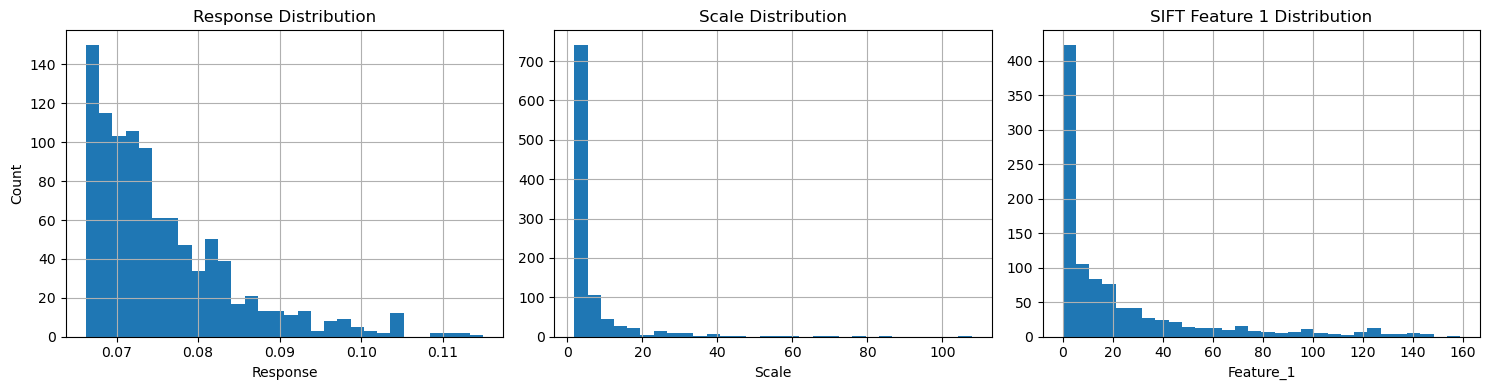

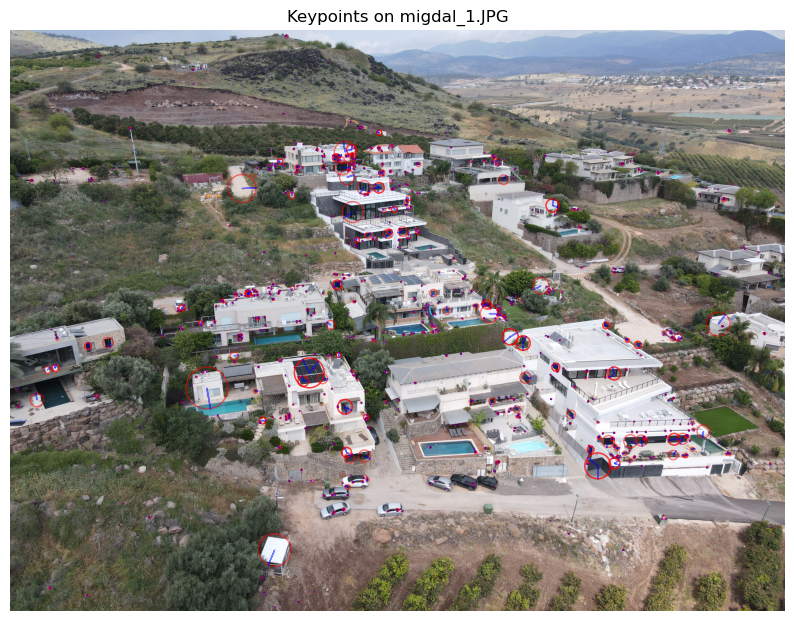

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the SIFT dataset
csv_path = 'dataset_migdal/migdal_1_sift_dataset.csv'
df = pd.read_csv(csv_path)

# 1. Print .head() and .describe()
print('First 5 rows:')
print(df.head())
print('\nSummary statistics:')
print(df.describe())

# 2. Plot histograms for Response, Scale, and a few SIFT features
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
df['Response'].hist(bins=30)
plt.title('Response Distribution')
plt.xlabel('Response')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
df['Scale'].hist(bins=30)
plt.title('Scale Distribution')
plt.xlabel('Scale')

plt.subplot(1, 3, 3)
df['Feature_1'].hist(bins=30)
plt.title('SIFT Feature 1 Distribution')
plt.xlabel('Feature_1')
plt.tight_layout()
plt.show()

# 3. Visualize keypoints on the image
img_path = 'dataset_migdal/migdal_1.JPG'
img = np.array(Image.open(img_path))

plt.figure(figsize=(10, 8))
plt.imshow(img)

# X, Y as position, Scale as radius, Angle as direction
x = df['X']
y = df['Y']
scale = df['Scale']
angle = df['Angle']

# Plot keypoints as circles
for i in range(len(df)):
    circ = plt.Circle((x[i], y[i]), scale[i], color='r', fill=False, alpha=0.5)
    plt.gca().add_patch(circ)
    # Draw direction arrow
    dx = np.cos(angle[i]) * scale[i]
    dy = np.sin(angle[i]) * scale[i]
    plt.arrow(x[i], y[i], dx, dy, color='b', head_width=2, head_length=2, alpha=0.5)

plt.title('Keypoints on migdal_1.JPG')
plt.axis('off')
plt.show()

## part A

In [19]:
from abc import ABC, abstractmethod
from sklearn.metrics import pairwise_distances

# === KNN (Linear search) ===
class KNN:
    def __init__(self, k=1):
        self.k = k

    def fit(self, X):
        self.X_train = X

    def neighbors(self, X_query):
        dists = pairwise_distances(X_query, self.X_train)
        idxs = np.argsort(dists, axis=1)[:, :self.k]
        dists_sorted = np.take_along_axis(dists, idxs, axis=1)
        return idxs, dists_sorted

# === Abstract class for ANN ===
class ANNBase(ABC):
    @abstractmethod
    def fit(self, X):
        pass

    @abstractmethod
    def neighbors(self, X_query):
        pass

# === LSH model ===
class LSH_ANN(ANNBase):
    def __init__(self, k=1, num_cuts=10, num_tables=5):
        self.k = k
        self.num_cuts = num_cuts
        self.num_tables = num_tables

    def fit(self, X):
        self.X_train = X
        np.random.seed(42)
        self.planes = [np.random.randn(X.shape[1], self.num_cuts) for _ in range(self.num_tables)]
        self.hash_tables = [self._hash(X, p) for p in self.planes]

    def neighbors(self, X_query):
        candidates = set()
        for plane, table in zip(self.planes, self.hash_tables):
            query_hash = self._hash(X_query, plane)
            for q in query_hash:
                matches = np.where((table == q).all(axis=1))[0]
                candidates.update(matches)
        if not candidates:
            return np.full((len(X_query), self.k), -1), np.full((len(X_query), self.k), np.inf)
        candidates = list(candidates)
        subset = self.X_train[candidates]
        dists = pairwise_distances(X_query, subset)
        idxs = np.argsort(dists, axis=1)[:, :self.k]
        real_idxs = np.array(candidates)[idxs]
        real_dists = np.take_along_axis(dists, idxs, axis=1)
        return real_idxs, real_dists

    def _hash(self, X, plane):
        return (X @ plane > 0).astype(int)

# === RKDT model (שלד) ===
class RKDT_ANN(ANNBase):
    def __init__(self, k=1, max_leaf=10, num_trees=5):
        self.k = k
        self.max_leaf = max_leaf
        self.num_trees = num_trees

    def fit(self, X):
        self.X_train = X  # מימוש בסיסי, עצים לא נבנים עדיין

    def neighbors(self, X_query):
        dists = pairwise_distances(X_query, self.X_train)
        idxs = np.argsort(dists, axis=1)[:, :self.k]
        dists_sorted = np.take_along_axis(dists, idxs, axis=1)
        return idxs, dists_sorted


# חילוץ תכונות בלבד (בלי X/Y/Scale)
feature_cols = [col for col in df.columns if col.startswith("Feature")]
X = df[feature_cols].values

# נניח שאנחנו לוקחים את 100 הדגימות הראשונות כ-set לאימון, וה-10 הבאות כ-test
X_train = X[:100]
X_test = X[100:110]

print("\n🔍 Running KNN:")
knn = KNN(k=1)
knn.fit(X_train)
idxs_knn, dists_knn = knn.neighbors(X_test)
print("Indices:\n", idxs_knn)
print("Distances:\n", dists_knn)

print("\n🔍 Running LSH_ANN:")
lsh = LSH_ANN(k=1, num_cuts=10, num_tables=5)
lsh.fit(X_train)
idxs_lsh, dists_lsh = lsh.neighbors(X_test)
print("Indices:\n", idxs_lsh)
print("Distances:\n", dists_lsh)

print("\n🔍 Running RKDT_ANN:")
rkdt = RKDT_ANN(k=1)
rkdt.fit(X_train)
idxs_rkdt, dists_rkdt = rkdt.neighbors(X_test)
print("Indices:\n", idxs_rkdt)
print("Distances:\n", dists_rkdt)




🔍 Running KNN:
Indices:
 [[24]
 [83]
 [75]
 [85]
 [83]
 [15]
 [14]
 [28]
 [85]
 [52]]
Distances:
 [[325.29832462]
 [221.17866082]
 [351.87071489]
 [248.0927246 ]
 [244.54651909]
 [372.47013303]
 [369.51995887]
 [367.98913027]
 [235.59499146]
 [221.94143372]]

🔍 Running LSH_ANN:
Indices:
 [[24]
 [83]
 [75]
 [85]
 [83]
 [15]
 [14]
 [75]
 [85]
 [52]]
Distances:
 [[325.29832462]
 [221.17866082]
 [351.87071489]
 [248.0927246 ]
 [244.54651909]
 [372.47013303]
 [369.51995887]
 [390.93094019]
 [235.59499146]
 [221.94143372]]

🔍 Running RKDT_ANN:
Indices:
 [[24]
 [83]
 [75]
 [85]
 [83]
 [15]
 [14]
 [28]
 [85]
 [52]]
Distances:
 [[325.29832462]
 [221.17866082]
 [351.87071489]
 [248.0927246 ]
 [244.54651909]
 [372.47013303]
 [369.51995887]
 [367.98913027]
 [235.59499146]
 [221.94143372]]


## part B


⏱️ Distance calculation runtime: 0.0083 seconds


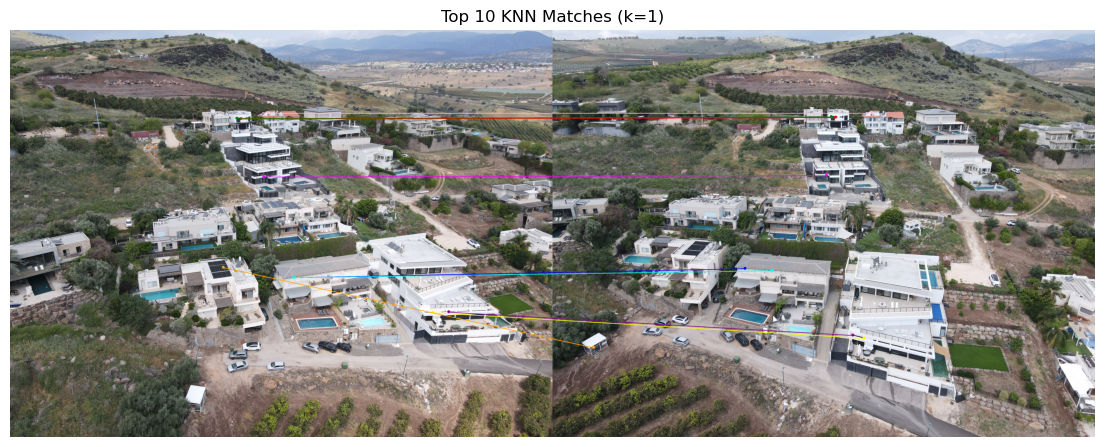

In [18]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from sklearn.metrics import pairwise_distances
import time
import matplotlib.pyplot as plt

# === 1. טען את הקבצים ===
df_train = pd.read_csv('dataset_migdal/migdal_1_sift_dataset.csv')  # סט אימון
df_test = pd.read_csv('dataset_migdal/migdal_2_sift_dataset.csv')   # סט בדיקה

# === 2. חילוץ תכונות SIFT בלבד ===
feature_cols = [col for col in df_train.columns if col.startswith('Feature')]
X_train = df_train[feature_cols].values
X_test = df_test[feature_cols].values

# === 3. חישוב מרחקים (KNN עם k=1) ===
start_time = time.time()
dists = pairwise_distances(X_test, X_train)
nearest_indices = np.argmin(dists, axis=1)
nearest_distances = np.min(dists, axis=1)
end_time = time.time()

print(f"\n⏱️ Distance calculation runtime: {end_time - start_time:.4f} seconds")

# === 4. בחירת 10 ההתאמות הטובות ביותר ===
top_10_idx = np.argsort(nearest_distances)[:10]

# === 5. טעינת התמונות ===
img1 = Image.open('dataset_migdal/migdal_1.JPG')  # אימון
img2 = Image.open('dataset_migdal/migdal_2.JPG')  # בדיקה

# השוואת גובה
if img1.height != img2.height:
    img2 = img2.resize((img2.width, img1.height))

# שילוב תמונות צד-לצד
combined_img = Image.new('RGB', (img1.width + img2.width, img1.height))
combined_img.paste(img1, (0, 0))
combined_img.paste(img2, (img1.width, 0))
draw = ImageDraw.Draw(combined_img)

colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'white', 'pink', 'purple']
r = 10
line_width = 6
offset = 3

for idx_num, idx in enumerate(top_10_idx):
    test_idx = idx
    train_idx = nearest_indices[test_idx]

    x1, y1 = df_train.loc[train_idx, ['X', 'Y']]
    x2, y2 = df_test.loc[test_idx, ['X', 'Y']]
    x2_shifted = x2 + img1.width

    color = colors[idx_num % len(colors)]

    # ציור נקודות עבות
    draw.ellipse((x1 - r, y1 - r, x1 + r, y1 + r), fill=color)
    draw.ellipse((x2_shifted - r, y2 - r, x2_shifted + r, y2 + r), fill=color)

    # ציור קו עבה יותר עם תזוזה קטנה כדי להבדיל
    draw.line([(x1 + offset, y1 + offset), (x2_shifted + offset, y2 + offset)], fill=color, width=line_width)

# === 7. הצגת התוצאה ===
plt.figure(figsize=(14, 7))
plt.imshow(combined_img)
plt.axis('off')
plt.title("Top 10 KNN Matches (k=1)")
plt.show()


## Part C

## Part D

## Part E